In [1]:
import fitsio
from fitsio import FITS, FITSHDR
from astropy import wcs
import autograd.numpy as np
from autograd import grad, jacobian, hessian_vector_product
import pandas as pd
import os
import matplotlib.pyplot as plt
import copy
%matplotlib notebook

# Some functions are not available in autograd.
import numpy as onp

from kernels import eval_cubic_kernel, eval_cubic_interpolation, eval_cubic_interpolation_same_spacing

In [2]:
git_path = os.environ['GIT_REPO_LOC']
data_path = os.path.join(git_path, 'DECamSurvey.jl/dat')
fname_head = 'c4d_160302_094418'
image_filename = os.path.join(data_path, fname_head + '_oki_z_v1.fits')
mask_filename = os.path.join(data_path, fname_head + '_ood_z_v1.fits')
dr3_object = fitsio.read_header(image_filename)['OBJECT']

In [3]:
# Load an image.
image_index = 3
image = fitsio.read(image_filename, ext=image_index)
image_mask = fitsio.read(mask_filename, ext=image_index)
header = fitsio.read_header(image_filename, ext=image_index)
im_wcs = wcs.WCS(header)
avsky = header["AVSKY"]
ccdnum = header["CCDNUM"]

print 'Good pixel proportion:'
print np.sum(image_mask == 0) / float(np.prod(image_mask.shape))
image[image_mask == 1] = float('nan')
# plt.matshow(np.log10(image), interpolation="nearest")
# plt.colorbar()

Good pixel proportion:
0.974422192838


In [4]:
# Load some CCD information.
decals_details_filename = os.path.join(data_path, 'survey-ccds-decals.fits')

# For some reason fitsio.read doesn't respect the order of the columns argument.
# To be safe, read them in one at a time.  I wonder what the best way to do this is.
decals_image_filename = fitsio.read(decals_details_filename, columns='IMAGE_FILENAME', ext=1)
decals_ccdnum = fitsio.read(decals_details_filename, columns='CCDNUM', ext=1)

found_row = False
row_index = -1
while not found_row and row_index < len(decals_image_filename):
    row_index += 1
    found_row = fname_head in decals_image_filename[row_index] and ccdnum == decals_ccdnum[row_index]

if found_row:
    ccdzpt = fitsio.read(decals_details_filename, rows=row_index, columns='CCDZPT', ext=1)
    exptime = fitsio.read(decals_details_filename, rows=row_index, columns='EXPTIME', ext=1)

    # For converting catalog fluxes to images
    count_per_flux = 1 / (10**((22.5 - ccdzpt) / 2.5) / exptime)
else:
    raise RuntimeError('File not found in DECams details')


In [5]:
# Load the catalog.

def get_brick_names_for_image(header, brick_filename):
    # First select the bricks that overlap with the image.
    ra_corners = [ header['COR%dRA1' % (i + 1)] for i in range(4)]
    dec_corners = [ header['COR%dDEC1' % (i + 1)] for i in range(4)]
    brick_select = \
      'ra2 > {ramin} && ra1 < {ramax} && dec2 > {decmin} && dec1 < {decmax}'.format(
          ramin=np.min(ra_corners), ramax=np.max(ra_corners),
          decmin=np.min(dec_corners), decmax=np.max(dec_corners))

    brick_fits = fitsio.FITS(brick_filename)
    keep_rows = brick_fits[1].where(brick_select) 
    bricks = brick_fits[1]['brickname'][keep_rows]
    brick_fits.close()
    
    return bricks

brick_filename = os.path.join(data_path, 'survey-bricks.fits')
bricks = get_brick_names_for_image(header, brick_filename)
print bricks


['1984p110' '1986p110' '1984p112' '1987p112']


In [6]:
def load_catalog(tractor_filename):
    tractor_fits = fitsio.FITS(tractor_filename)
    tractor_header = fitsio.read_header(tractor_filename, ext=1)
    catalog_cols = [ 'type', 'ra', 'dec', 'cpu_source', 'decam_flux', 'wise_flux',
                      'fracdev', 'shapeexp_r', 'shapedev_r' ]

    objid = tractor_fits[1]['objid'][:]

    catalog_df = pd.DataFrame({'objid': objid})
    for catalog_col in catalog_cols:
        tractor_data = tractor_fits[1][catalog_col][:]
        if len(tractor_data.shape) == 1:
            catalog_df[catalog_col] = tractor_data
        else:
            for col in range(tractor_data.shape[1]):
                catalog_df[catalog_col + str(col + 1)] = tractor_data[:, col]

    return catalog_df

tractor_filenames = \
    [ os.path.join(data_path, 'tractor-{brickname}.fits'.format(brickname=brick)) \
      for brick in bricks]

catalog_df = pd.concat([ load_catalog(fname) for fname in tractor_filenames ])

# Have to trim whitespace from the type for some reason.
catalog_df['type'] = catalog_df['type'].map(lambda t: t.strip())

print catalog_df.shape

(11122, 18)


In [7]:
# Filter the catalog to objects located in the current image.  Note that,
# unlike Julia, I will use zero indexing to match Python.
pix = im_wcs.wcs_world2pix(catalog_df[['ra', 'dec']].as_matrix(), 0)

# Note that the image is transposed relative to Julia, so the image is indexed [pix_w, pix_h].
print np.min(pix, 0)
print np.max(pix, 0)
print image.shape

row_in_image = \
    onp.logical_and.reduce([ pix[:, 0] >= 0,
                             pix[:, 0] <= image.shape[1] - 1,
                             pix[:, 1] >= 0,
                             pix[:, 1] <= image.shape[0] - 1 ])

catalog_df = catalog_df[row_in_image]
catalog_df['pix_h'] = pix[row_in_image, 0]
catalog_df['pix_w'] = pix[row_in_image, 1]
print catalog_df.shape

[-3158.23405395 -1956.63426665]
[ 3865.51047988  5399.76275359]
(4094, 2046)
(2088, 20)


In [8]:
# Display the catalog objects.
bright_rows = catalog_df['decam_flux5'] > 300

plt.matshow(np.log10(image))
plt.colorbar()
plt.plot(catalog_df[bright_rows]['pix_h'], catalog_df[bright_rows]['pix_w'], 'ro')

<IPython.core.display.Javascript object>

In [9]:
# This is an L_\infty "radius".
def get_pixel_box(pix_h, pix_w, pix_radius, image_shape):
    h_min = np.max([int(np.floor(pix_h - pix_radius)), 0])
    w_min = np.max([int(np.floor(pix_w - pix_radius)), 0])
    h_max = np.min([int(np.ceil(pix_h + pix_radius)), image_shape[1]])
    w_max = np.min([int(np.ceil(pix_w + pix_radius)), image_shape[0]])

    return slice(h_min, h_max), slice(w_min, w_max)
        
h_slice, w_slice = get_pixel_box(3, 100.1, 3.1, image.shape)
print image[w_slice, h_slice]

[[ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]]


In [10]:
# Filter out galaxy pixels.

filter_image = copy.deepcopy(image)
# print [ type.strip() for type in catalog_df['type'] ]
# gal_rows = [ type.strip() == 'PSF' for type in catalog_df['type'] ] 
gal_rows = catalog_df['type'] != 'PSF'

print 'Proportion of objects that are galaxies:'
print np.sum(gal_rows) / float(catalog_df.shape[0])

for index, row in catalog_df[gal_rows].iterrows():
    # These radii are in pixels.
    radius = np.max([8 * row['shapedev_r'], 8 * row['shapeexp_r'], 3.0])
    h_slice, w_slice = get_pixel_box(row['pix_h'], row['pix_w'], radius, filter_image.shape)
    filter_image[w_slice, h_slice] = float('nan')


Proportion of objects that are galaxies:
0.528735632184


In [11]:
#plt.matshow(np.log10(filter_image))
#plt.colorbar()
#plt.plot(catalog_df[gal_rows]['pix_h'], catalog_df[gal_rows]['pix_w'], 'ro')

In [12]:
# Pick a star to look at.

bright_star_rows = np.logical_and(catalog_df['type'] == 'PSF', catalog_df['decam_flux5'] > 300)
row = catalog_df[bright_star_rows].iloc[0]
h_slice, w_slice = get_pixel_box(row['pix_h'], row['pix_w'], 10, filter_image.shape)

star_psf_scale = count_per_flux * row['decam_flux5']

plt.matshow(filter_image[w_slice, h_slice])
star_pix_loc = [row['pix_w'] - w_slice.start, row['pix_h'] - h_slice.start]
plt.plot(star_pix_loc[0], star_pix_loc[1], 'ro')
plt.colorbar()

<IPython.core.display.Javascript object>

In [13]:
# Make a little gaussian image for a PSF.

psf_size = 15
psf_image = np.zeros([psf_size, psf_size])
psf_center = np.array([ 0.5 * (float(psf_image.shape[0]) - 1), 0.5 * (float(psf_image.shape[1]) - 1)])
gauss_loc = np.array(psf_center)
gauss_var = 0.75**2
for x, y in np.ndindex(psf_image.shape):
    psf_image[x, y] = np.exp(-0.5 * np.linalg.norm(np.array([x, y]) - gauss_loc) / gauss_var)
    
psf_image = psf_image / np.sum(psf_image)
plt.matshow(psf_image)


<IPython.core.display.Javascript object>

(15, 15)
(11, 11)
(11, 11)


<IPython.core.display.Javascript object>


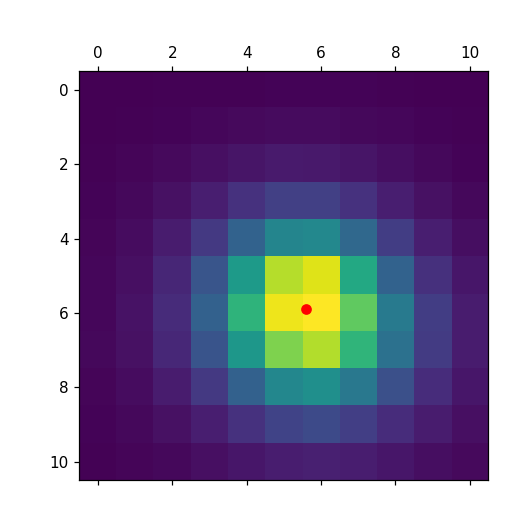

<IPython.core.display.Javascript object>


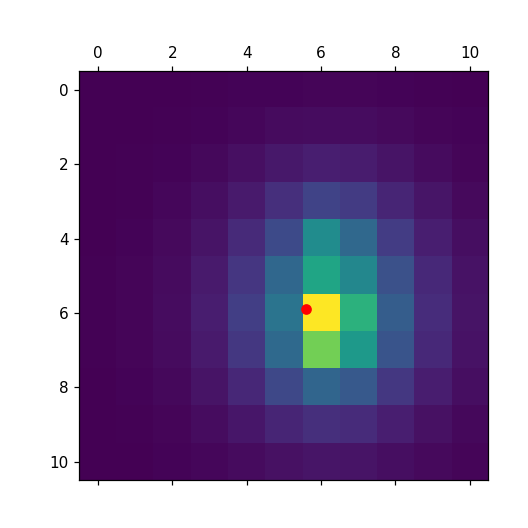

In [30]:
star_loc_offset = star_pix_loc - psf_center
star_int_offset = [ int(np.floor(x)) for x in star_loc_offset ]
star_delta = star_loc_offset - star_int_offset

# This slice is where the interpolated PSF would go in the star image if the star_delta were zero.
# Subtract two pixels from each side for the interpolation.
w_psf_slice = slice(star_int_offset[0] + 2, star_int_offset[0] + psf_image.shape[0] - 2)
h_psf_slice = slice(star_int_offset[1] + 2, star_int_offset[1] + psf_image.shape[1] - 2)

psf_interp = eval_cubic_interpolation_same_spacing(star_delta, star_psf_scale * psf_image, 2.0)

print psf_image.shape
print psf_interp.shape
print filter_image[w_slice, h_slice][w_psf_slice, h_psf_slice].shape

plt.matshow(filter_image[w_slice, h_slice][w_psf_slice, h_psf_slice])
plt.plot(star_delta[0] + psf_center[0] - 2, star_delta[1] + psf_center[1] - 2, 'ro')

plt.matshow(psf_interp)
plt.plot(star_delta[0] + psf_center[0] - 2, star_delta[1] + psf_center[1] - 2, 'ro')


<IPython.core.display.Javascript object>


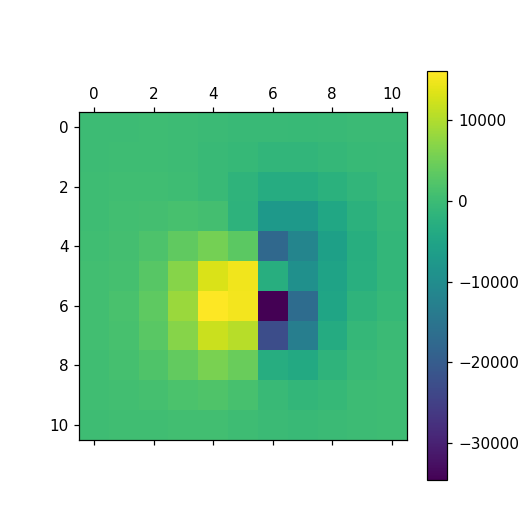

In [38]:

#star_image = np.full_like(filter_image[w_slice, h_slice], avsky)
def image_residuals(star_delta, psf_image, star_psf_scale):
    star_image = eval_cubic_interpolation_same_spacing(star_delta, star_psf_scale * psf_image, 2.0) + avsky
    return filter_image[w_slice, h_slice][w_psf_slice, h_psf_slice] - star_image

resid = image_residuals(star_delta, psf_image, star_psf_scale)
plt.matshow(resid)
plt.colorbar()


<IPython.core.display.Javascript object>


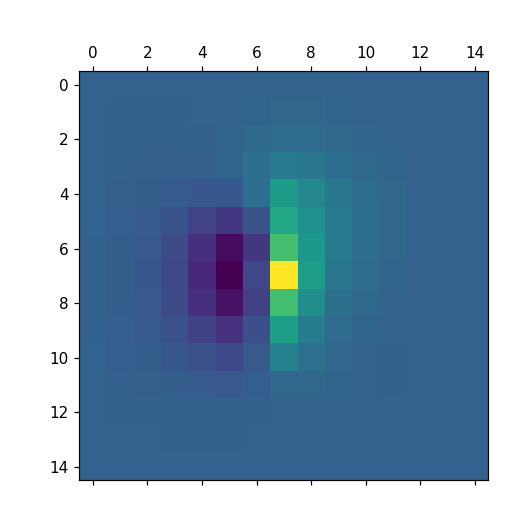

In [40]:
def image_error(psf_image):
    return np.sum(image_residuals(star_delta, psf_image, star_psf_scale)**2)

image_error(psf_image)
image_error_jac = jacobian(image_error)
#plt.matshow(image_error_jac(psf_image))


In [49]:
psf_min = 0.001
def wrap_psf(psf_image):
    return np.log(np.ndarray.flatten(psf_image) + psf_min)

def unwrap_psf(psf_vec, psf_shape):
    return np.reshape(np.exp(psf_vec) - psf_min, psf_shape)

wrap_psf(psf_image).shape
np.max(np.abs(psf_image - unwrap_psf(wrap_psf(psf_image), psf_image.shape)))


2.7755575615628914e-17

In [ ]:
import scipy as sp

import copy
from scipy import optimize

def image_error_wrap(psf_vec):
    local_psf_image = unwrap_psf(psf_vec, psf_image.shape)
    sq_error = np.sum(image_residuals(star_delta, local_psf_image, star_psf_scale)**2) 
    print sq_error
    return sq_error

psf_vec = wrap_psf(psf_image)

image_error_grad = grad(image_error_wrap)
image_error_hvp = hessian_vector_product(image_error_wrap)

psf_opt = optimize.minimize(
    image_error_wrap,
    psf_vec, method='trust-ncg', jac=image_error_grad, hessp=image_error_hvp,
    tol=1e-6, options={'maxiter': 100, 'disp': True, 'gtol': 1e-6 })



Autograd ArrayNode with value 4502540901.82 and 1 progenitors(s)
Autograd ArrayNode with value 4502540901.82 and 2 progenitors(s)
4502540901.82
Autograd ArrayNode with value 4502540901.82 and 2 progenitors(s)
2205651131.88
Autograd ArrayNode with value 2205651131.88 and 1 progenitors(s)
Autograd ArrayNode with value 2205651131.88 and 2 progenitors(s)
Autograd ArrayNode with value 2205651131.88 and 2 progenitors(s)
1331688398.67
Autograd ArrayNode with value 1331688398.67 and 1 progenitors(s)
Autograd ArrayNode with value 1331688398.67 and 2 progenitors(s)
Autograd ArrayNode with value 1331688398.67 and 2 progenitors(s)
727127138.514
Autograd ArrayNode with value 727127138.514 and 1 progenitors(s)
Autograd ArrayNode with value 727127138.514 and 2 progenitors(s)
Autograd ArrayNode with value 727127138.514 and 2 progenitors(s)
526208782.347
Autograd ArrayNode with value 526208782.347 and 1 progenitors(s)
Autograd ArrayNode with value 526208782.347 and 2 progenitors(s)
Autograd ArrayNode w

Autograd ArrayNode with value 6401893.74429 and 2 progenitors(s)
Autograd ArrayNode with value 6401893.74429 and 2 progenitors(s)
6139468.69504
Autograd ArrayNode with value 6139468.69504 and 1 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd ArrayNode with value 6139468.69504 and 2 progenitors(s)
Autograd Ar

Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with value 4830286.63127 and 2 progenitors(s)
Autograd ArrayNode with v

Autograd ArrayNode with value 4537270.00411 and 2 progenitors(s)
Autograd ArrayNode with value 4537270.00411 and 2 progenitors(s)
